In [2]:
import numpy as np
import pandas as pd

In [120]:
from sklearn.utils import resample
df_train = pd.read_csv('C:/Users/User/PycharmProjects/Earthquake/Student Hiring Project 2017 - Training Data.txt', header=None)

In [ ]:
# Separate majority and minority classes
df_majority = df_train[df_train.iloc[:, -1] == 0]  # Assuming the last column is the target
df_minority = df_train[df_train.iloc[:, -1] == 1]

## Visualization of Data

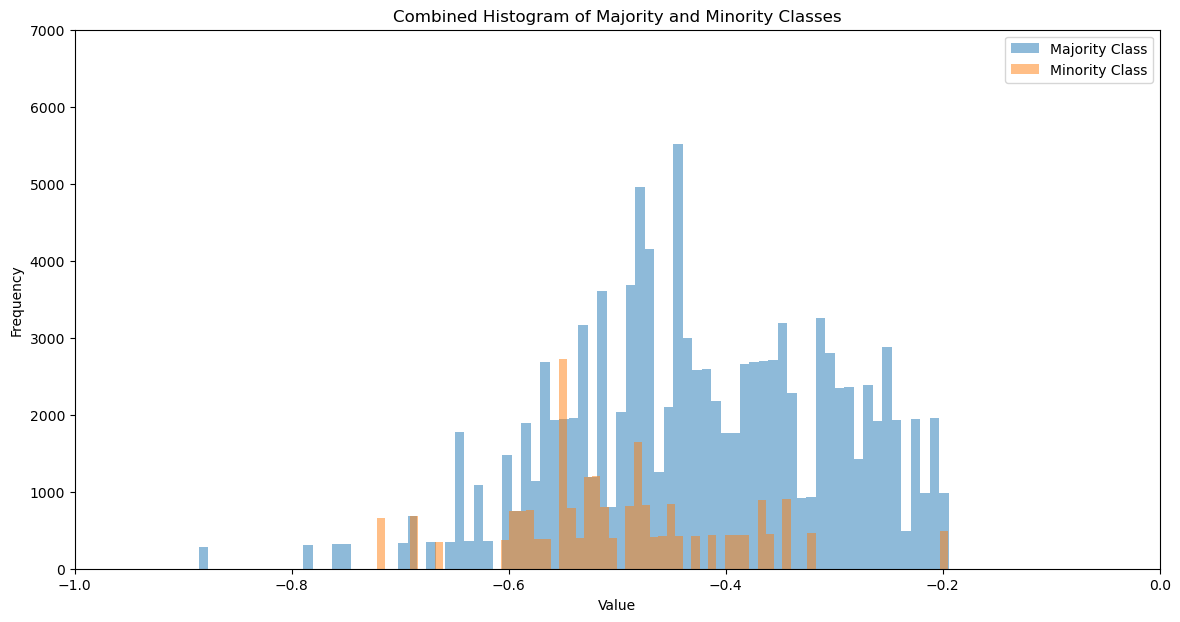

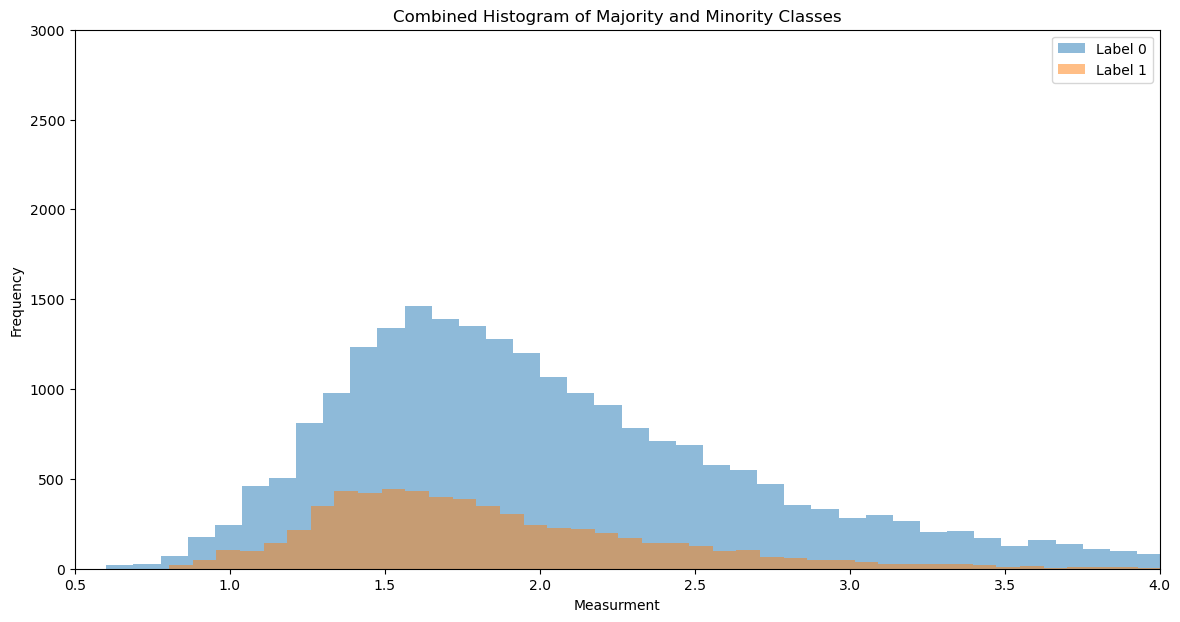

In [115]:
import matplotlib.pyplot as plt

# Flatten the data
flattened_majority = df_majority.iloc[:, :-1].values.flatten()
flattened_minority = df_minority.iloc[:, :-1].values.flatten()

# Plot histograms
plt.figure(figsize=(14, 7))

# Majority histogram
plt.hist(flattened_majority, bins=1000, alpha=0.5, label='Majority Class')

# Minority histogram
plt.hist(flattened_minority, bins=1000, alpha=0.5, label='Minority Class')

plt.title('Combined Histogram of Majority and Minority Classes')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(-1, 0)
plt.ylim(0, 7000)

plt.show()
# Plot histograms
plt.figure(figsize=(14, 7))

# Majority histogram
plt.hist(flattened_majority, bins=100, alpha=0.5, label='Label 0')

# Minority histogram
plt.hist(flattened_minority, bins=100, alpha=0.5, label='Label 1')

plt.title('Combined Histogram of Majority and Minority Classes')
plt.xlabel('Measurment')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(0.5, 4)
plt.ylim(0, 3000)

plt.show()

In [121]:
# Count the number of occurrences for each class in the last column (target column)
class_counts = df_train.iloc[:, -1].value_counts()

# Display the counts
print(class_counts)


512
0    264
1     58
Name: count, dtype: int64


## Given the clear imbalance we'll upsample the minority class

In [43]:
from sklearn.utils import resample

# Upsampling minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),  # to match majority class
                                 random_state=123)  # reproducible results

# Combining majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Displaying new class counts
print(df_upsampled.iloc[:, -1].value_counts())


512
0    264
1    264
Name: count, dtype: int64


In [49]:
df_upsampled.reset_index(drop=True, inplace=True)


## LSTM

In [148]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from scikeras.wrappers import KerasClassifier
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Split data into features and labels
X_raw = df_train.iloc[:, :-1].values  # all rows, all columns except the last one
y = df_train.iloc[:, -1].values   # all rows, only the last column

# Scale the features
scaler = StandardScaler()
X_raw_scaled = scaler.fit_transform(X_raw)


def create_lstm_model():
    # ... LSTM model definition ...
    model = Sequential()
    model.add(LSTM(50, input_shape=(512, 1)))  # Adjust according to your LSTM's expected input
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model with KerasClassifier
# from keras.wrappers.scikit_learn import KerasClassifier
lstm_model = KerasClassifier(model=create_lstm_model, epochs=10, batch_size=32, verbose=0)

X_raw_scaled_reshaped = X_raw_scaled.reshape((X_raw_scaled.shape[0], X_raw_scaled.shape[1], 1))


# Generate out-of-fold predictions for LSTM; you may need to modify the X data to match LSTM input shape
lstm_oof_pred = cross_val_predict(lstm_model, X_raw_scaled_reshaped, y, cv=cv, method='predict_proba')
lstm_oof_class_pred = (lstm_oof_pred[:, 1] > 0.5).astype(int)  # Assuming the second column for the positive class

# Now generate the classification report
report = classification_report(y, lstm_oof_class_pred)
print(report)

KeyboardInterrupt: 

In [139]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Split data into features and labels
X_raw = df_train.iloc[:, :-1].values  # all rows, all columns except the last one
y_raw = df_train.iloc[:, -1].values   # all rows, only the last column

# Scale the features
scaler = StandardScaler()
X_raw_scaled = scaler.fit_transform(X_raw)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_raw_scaled, y_raw, test_size=0.2, random_state=42)

# Reshape the data for LSTM: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [140]:
import tensorflow as tf
lstm_model = Sequential()
# tf.keras.backend.experimental.enable_tf_random_generator()
lstm_model.add(LSTM(50, input_shape=(512, 1)))  # 50 LSTM units, 512 time steps, 1 feature per step
lstm_model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [146]:
from sklearn.metrics import classification_report

# Train the model
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Predict classes on the test set
y_pred = lstm_model.predict(X_test)
# If your model outputs probabilities, you may need to threshold them to get binary class predictions
# This assumes a binary classification with a threshold of 0.5
y_pred_labels = (y_pred > 0.3).astype(int)

# Evaluate the model
test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)

# Generate the classification report
report = classification_report(y_test, y_pred_labels, target_names=['Class 0', 'Class 1'])
print(report)

print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')


Epoch 1/10
7/7 [==============================] - 1s 212ms/step - loss: 0.4562 - accuracy: 0.8098 - val_loss: 0.3629 - val_accuracy: 0.8654
Epoch 2/10
7/7 [==============================] - 1s 204ms/step - loss: 0.4559 - accuracy: 0.8146 - val_loss: 0.3646 - val_accuracy: 0.8654
Epoch 3/10
7/7 [==============================] - 2s 236ms/step - loss: 0.4537 - accuracy: 0.8146 - val_loss: 0.3653 - val_accuracy: 0.8654
Epoch 4/10
7/7 [==============================] - 2s 285ms/step - loss: 0.4549 - accuracy: 0.8098 - val_loss: 0.3688 - val_accuracy: 0.8654
Epoch 5/10
7/7 [==============================] - 2s 231ms/step - loss: 0.4539 - accuracy: 0.8146 - val_loss: 0.3681 - val_accuracy: 0.8462
Epoch 6/10
7/7 [==============================] - 2s 228ms/step - loss: 0.4516 - accuracy: 0.8146 - val_loss: 0.3601 - val_accuracy: 0.8654
Epoch 7/10
7/7 [==============================] - 2s 236ms/step - loss: 0.4539 - accuracy: 0.8195 - val_loss: 0.3573 - val_accuracy: 0.8654
Epoch 8/10
7/7 [====

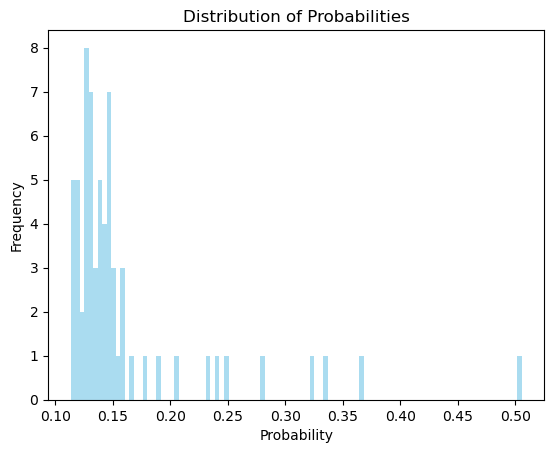

In [145]:
import matplotlib.pyplot as plt

# Assuming y_pred is your array of probabilities
plt.hist(y_pred, bins=100, color='skyblue', alpha=0.7)
plt.title('Distribution of Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()


In [ ]:
df_train

In [16]:


# Prepare a list to hold all the data
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame and the last column is the label
features = df_upsampled.iloc[:, :-1]  # exclude the label column

# Calculate the desired statistics
min_vals = features.min(axis=1)
max_vals = features.max(axis=1)
mean_vals = features.mean(axis=1)
std_vals = features.std(axis=1)
most_common_vals = features.mode(axis=1)[0]  # mode returns a DataFrame, select the first column

# Create a new DataFrame with these features
df_featured = pd.DataFrame({
    'min': min_vals,
    'max': max_vals,
    'mean': mean_vals,
    'std': std_vals,
    'most_common_value': most_common_vals,
    'label': df_upsampled.iloc[:, -1]  # add the labels back
})

print(df_featured.head())  # Show the first few rows of the new dataset


In [28]:
filtered_df = df_featured[df_featured['Max'] > 5]
print(filtered_df)

         Min     Max          Mean       Std  Label
5   -0.24025  6.0425 -3.027344e-06  0.999024      0
8   -0.20715  7.5787 -3.515625e-06  0.999026      0
12  -0.20405  6.7908 -1.074219e-06  0.999024      0
13  -0.26656  5.2691  1.718750e-06  0.999024      0
21  -0.25160  6.4258  1.757813e-06  0.999023      0
24  -0.19825  6.9052 -7.812500e-07  0.999024      1
36  -0.25822  5.6711 -2.304688e-06  0.999023      0
44  -0.28802  5.1532 -4.296875e-07  0.999021      0
51  -0.21806  7.4394 -2.695312e-06  0.999025      0
53  -0.33812  5.3003  3.593750e-06  0.999022      0
67  -0.22808  6.7781 -1.914062e-06  0.999021      0
69  -0.23762  5.4372 -3.867188e-06  0.999023      0
93  -0.25316  6.8365 -4.687500e-06  0.999021      0
97  -0.26738  5.3284 -4.609375e-06  0.999024      0
111 -0.28814  6.3783 -7.812500e-08  0.999023      0
126 -0.24918  5.7995  4.140625e-06  0.999023      0
138 -0.29102  5.1573 -7.812500e-07  0.999023      0
140 -0.26765  6.9440 -3.320313e-06  0.999024      0
142 -0.30417

##Getting rid of index 24, this index doesn't fulfill the requirment that a major event occurence
 over the last 512 hours was labeled 1 

In [12]:
# Dropping the index which doesn't meet the criterion
df_featured = df_featured.drop(index=24)


In [30]:
label_counts = df_featured.iloc[:, -1].value_counts()
label_counts

Label
0    264
1     57
Name: count, dtype: int64

We can see some imbalance in the data. We will create 2 models one the original data and one with an 
oversampling of the minority class and we'll check which performs better.
## Logistic regression with imbalanced data

In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report

# Loading the DataFrame 'df' with the last column as the target
X = df_featured.iloc[:, :-1]
y = df_featured.iloc[:, -1]

# Normalizing the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Setting up stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Creating a logistic regression model
model = LogisticRegression()

# Generating cross-validated predictions
y_pred = cross_val_predict(model, X_scaled, y, cv=skf)

# Printing the classification report
print(classification_report(y, y_pred))


              precision    recall  f1-score   support

           0       0.82      1.00      0.90       264
           1       0.00      0.00      0.00        57

    accuracy                           0.82       321
   macro avg       0.41      0.50      0.45       321
weighted avg       0.68      0.82      0.74       321


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Upsampling the minority class

## Logistic regression with balanced data

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report

# Loading the DataFrame 'df' with the last column as the target
X = df_upsampled.iloc[:, :-1]
y = df_upsampled.iloc[:, -1]

# Normalizing the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Set up a stratified K-Fold for cross-validation to maintain the class balance in each fold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Using cross_val_predict to get predictions from each fold of cross-validation
y_pred = cross_val_predict(model, X_scaled, y, cv=cv)

# Printing the classification report, which includes precision, recall, and F1-score
print(classification_report(y, y_pred))



              precision    recall  f1-score   support

           0       0.72      0.58      0.64       264
           1       0.65      0.78      0.71       264

    accuracy                           0.68       528
   macro avg       0.69      0.68      0.67       528
weighted avg       0.69      0.68      0.67       528


We can see a drastic improvment in the f1 score and Recall in the model with the balanced dataset

## Checking the metrics on the test set

In [34]:
from sklearn.metrics import classification_report

# Assume X_train, y_train are your entire training feature set and labels
# X_test, y_test are your test feature set and labels
X_train = df_upsampled.iloc[:, :-1]
y_train = df_upsampled.iloc[:, -1]

X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]
# Fit the scaler on the training set
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test set with the same scaler
X_test_scaled = scaler.transform(X_test)

# Train the model on the entire training set
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_test_pred = model.predict(X_test_scaled)

# Generating a classification report
print(classification_report(y_test, y_test_pred))

# confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(conf_matrix)


              precision    recall  f1-score   support

           0       0.86      0.55      0.67       104
           1       0.36      0.74      0.48        35

    accuracy                           0.60       139
   macro avg       0.61      0.65      0.58       139
weighted avg       0.74      0.60      0.62       139

[[57 47]
 [ 9 26]]


In [19]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
X_train = df_upsampled.iloc[:, :-1]
y_train = df_upsampled.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]
# Define a dictionary of models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(),
    'Neural Network': MLPClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression()
}

# Fit the scaler on the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Iterating over models and evaluate each one
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    model.fit(X_train_scaled, y_train)
    y_test_pred = model.predict(X_test_scaled)
    print(classification_report(y_test, y_test_pred))



Evaluating Random Forest...
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       104
           1       0.33      0.20      0.25        35

    accuracy                           0.70       139
   macro avg       0.55      0.53      0.53       139
weighted avg       0.65      0.70      0.67       139

Evaluating Gradient Boosting...
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       104
           1       0.43      0.34      0.38        35

    accuracy                           0.72       139
   macro avg       0.61      0.59      0.60       139
weighted avg       0.70      0.72      0.71       139

Evaluating SVM...
              precision    recall  f1-score   support

           0       0.86      0.58      0.69       104
           1       0.36      0.71      0.48        35

    accuracy                           0.61       139
   macro avg       0.61      0.65      0.59       

C:\Users\User\anaconda3\envs\mycondaenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [54]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report

# Loading the DataFrame 'df' with the last column as the target
X = df_featured.iloc[:, :-1]
y = df_featured.iloc[:, -1]

# Normalizing the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Set up a stratified K-Fold for cross-validation to maintain the class balance in each fold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create a GaussianNB model
nb_model = GaussianNB()

# Using cross_val_predict to get predictions from each fold of cross-validation
y_pred = cross_val_predict(nb_model, X_scaled, y, cv=cv)

# Printing the classification report, which includes precision, recall, and F1-score
print(classification_report(y, y_pred))



              precision    recall  f1-score   support

           0       0.69      0.45      0.55       264
           1       0.59      0.80      0.68       264

    accuracy                           0.62       528
   macro avg       0.64      0.62      0.61       528
weighted avg       0.64      0.62      0.61       528


In [56]:
# Note: Ensure you have the `cross_val_predict` function and the `StratifiedKFold` object as before
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scikeras.wrappers import KerasClassifier
# First, we generate out-of-fold predictions for the Naive Bayes model
nb_oof_pred = cross_val_predict(nb_model, X_scaled, y, cv=cv, method='predict_proba')

# Now, for the LSTM model, we'll need to create a function that returns the model
# and use cross_val_predict with KerasClassifier to get out-of-fold predictions
def create_lstm_model():
    # ... LSTM model definition ...
    model = Sequential()
    model.add(LSTM(50, input_shape=(512, 1)))  # Adjust according to your LSTM's expected input
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model with KerasClassifier
# from keras.wrappers.scikit_learn import KerasClassifier
lstm_model = KerasClassifier(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0)

X_raw_scaled_reshaped = X_raw_scaled.reshape((X_raw_scaled.shape[0], X_raw_scaled.shape[1], 1))


# Generate out-of-fold predictions for LSTM; you may need to modify the X data to match LSTM input shape
lstm_oof_pred = cross_val_predict(lstm_model, X_raw_scaled_reshaped, y, cv=cv, method='predict_proba')

# Combine the out-of-fold predictions to use as new features
stacked_features = np.concatenate((nb_oof_pred, lstm_oof_pred), axis=1)

# Define the meta-classifier
meta_classifier = LogisticRegression()

# Fit the meta-classifier on the out-of-fold predictions
meta_classifier.fit(stacked_features, y)

# Now you can use meta_classifier.predict() to make predictions on new data
# Make sure to generate the same features from your LSTM and Naive Bayes models for the new data

# Evaluate the stacking ensemble
print(classification_report(y, meta_classifier.predict(stacked_features)))


C:\Users\User\anaconda3\envs\mycondaenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\User\anaconda3\envs\mycondaenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\User\anaconda3\envs\mycondaenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\User\anaconda3\envs\mycondaenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y =

C:\Users\User\anaconda3\envs\mycondaenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


C:\Users\User\anaconda3\envs\mycondaenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\User\anaconda3\envs\mycondaenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\User\anaconda3\envs\mycondaenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\User\anaconda3\envs\mycondaenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y =

              precision    recall  f1-score   support

           0       0.65      0.66      0.66       264
           1       0.66      0.65      0.65       264

    accuracy                           0.66       528
   macro avg       0.66      0.66      0.66       528
weighted avg       0.66      0.66      0.66       528


In [57]:
import pandas as pd
import numpy as np
df_test = pd.read_csv('C:/Users/User/PycharmProjects/Earthquake/Student Hiring Project 2017 - Training Data.txt', header=None)
# Assuming 'df' is your DataFrame and the last column is the label
test_features = df_test.iloc[:, :-1]  # exclude the label column

# Calculate the desired statistics
min_vals = test_features.min(axis=1)
max_vals = test_features.max(axis=1)
mean_vals = test_features.mean(axis=1)
std_vals = test_features.std(axis=1)
most_common_vals = test_features.mode(axis=1)[0]  # mode returns a DataFrame, select the first column

# Create a new DataFrame with these features
df_test_featured = pd.DataFrame({
    'min': min_vals,
    'max': max_vals,
    'mean': mean_vals,
    'std': std_vals,
    'most_common_value': most_common_vals,
    'label': df_test.iloc[:, -1]  # add the labels back
})
X_test_featured = df_test_featured.iloc[:, :-1]
y_test = df_test_featured.iloc[:, -1]

In [62]:



# Normalizing the features
nb_model = GaussianNB()
nb_model.fit(X_scaled, y)
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test_featured)
nb_test_pred = nb_model.predict_proba(X_test_scaled)



# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from scikeras.wrappers import KerasClassifier

# Function to create the LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(512, 1)))  # Adjust the input shape based on your data
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model with KerasClassifier
lstm_model = KerasClassifier(model=create_lstm_model, epochs=50, batch_size=20, verbose=0)

# Fit the model on the training data
# X_train_reshaped should be your input features reshaped to fit the LSTM input requirements
# y_train should be your target/output variable
lstm_model.fit(X_raw_scaled_reshaped, y)

scaler = StandardScaler()
X_raw_test_scaled = scaler.fit_transform(test_features)

X_test_reshaped = X_raw_test_scaled.reshape((X_raw_test_scaled.shape[0],X_raw_test_scaled.shape[1], 1))

lstm_test_pred = lstm_model.predict_proba(X_test_reshaped)

stacked_test_features = np.concatenate((nb_test_pred, lstm_test_pred), axis=1)

final_predictions = meta_classifier.predict(stacked_test_features)

print(classification_report(y_test, final_predictions))


              precision    recall  f1-score   support

           0       0.95      0.39      0.56       264
           1       0.25      0.91      0.39        58

    accuracy                           0.49       322
   macro avg       0.60      0.65      0.47       322
weighted avg       0.83      0.49      0.53       322


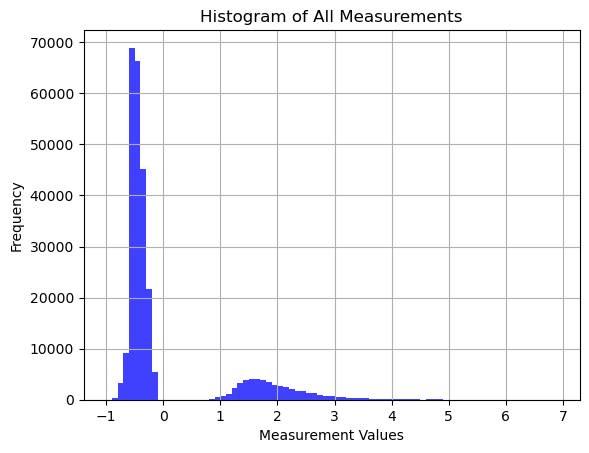

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' is your DataFrame containing the measurements

# Flatten the data into a single array
flattened_data = X_raw.flatten()
# Define bins with a step of 0.1
bins = np.arange(-1,7 , 0.1)
# Plot a histogram of the flattened data
plt.hist(flattened_data, bins=bins, alpha=0.75, color='blue')
plt.title('Histogram of All Measurements')
plt.xlabel('Measurement Values')
plt.ylabel('Frequency')
plt.grid(True)

# plt.xlim(0, 6)

plt.show()


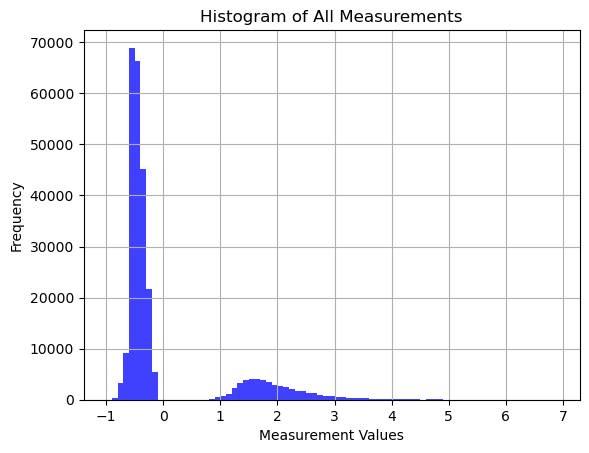

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' is your DataFrame containing the measurements
# df_majority = df_train[df_train.iloc[:, -1] == 0]  # Assuming the last column is the target
# df_minority = df_train[df_train.iloc[:, -1] == 1]
# Flatten the data into a single array
flattened_data = X_raw.flatten()
# Define bins with a step of 0.1
bins = np.arange(-1,7 , 0.1)
# Plot a histogram of the flattened data
plt.hist(flattened_data, bins=bins, alpha=0.75, color='blue')
plt.title('Histogram of All Measurements')
plt.xlabel('Measurement Values')
plt.ylabel('Frequency')
plt.grid(True)

# plt.xlim(0, 6)

plt.show()


In [93]:
df_minority.iloc[:, :-1].head()


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.51801,-0.51801,2.65420,-0.51801,-0.51801,-0.51801,-0.51801,1.45620,2.55840,-0.51801,...,-0.51801,-0.51801,-0.51801,-0.51801,-0.51801,-0.51801,-0.51801,-0.51801,1.46580,-0.51801
4,-0.59366,2.02010,1.17470,-0.59366,-0.59366,1.60600,1.21790,1.58880,-0.59366,-0.59366,...,1.22650,-0.59366,-0.59366,-0.59366,1.49390,-0.59366,-0.59366,-0.59366,1.89930,-0.59366
22,-0.48066,-0.48066,-0.48066,-0.48066,1.75460,-0.48066,-0.48066,-0.48066,-0.48066,-0.48066,...,-0.48066,3.01930,1.90170,1.85270,-0.48066,-0.48066,-0.48066,-0.48066,-0.48066,-0.48066
24,-0.19825,-0.19825,-0.19825,-0.19825,4.88960,-0.19825,-0.19825,-0.19825,-0.19825,-0.19825,...,-0.19825,-0.19825,-0.19825,-0.19825,-0.19825,-0.19825,-0.19825,-0.19825,-0.19825,-0.19825
27,-0.49262,-0.49262,-0.49262,-0.49262,-0.49262,1.42600,-0.49262,-0.49262,-0.49262,-0.49262,...,3.42670,3.00850,1.64740,2.50020,1.51620,3.18070,2.97570,2.42640,2.61500,3.23810
